Till now we have predicted Images using standard Uniform Images , i.e the images all have standard size, in one rotation, and is uniform. In real world, the images are all not that uniform and some maybe of different size and different orientation.

To Solve this we can use Tensorflow's [``Image generator``](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) api to be able to generate randomness in our images.

In this notebook we will work around Horse vs Humans classification and look into different method that can be used to improve accuracy


In [1]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

--2024-07-29 07:32:13--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.207, 142.250.152.207, 173.194.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M   175MB/s    in 0.8s    

2024-07-29 07:32:14 (175 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]



In [2]:
import zipfile

# Unzip the dataset
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')
zip_ref.close()

The contents of the .zip are extracted to the base directory ./horse-or-human, which in turn each contain horses and humans subdirectories.

In short: The training set is the data that is used to tell the neural network model that 'this is what a horse looks like' and 'this is what a human looks like'.

One thing to pay attention to in this sample: We do not explicitly label the images as horses or humans. You will use the ImageDataGenerator API instead -- and this is coded to automatically label images according to the directory names and structure. So, for example, you will have a 'training' directory containing a 'horses' directory and a 'humans' one. ImageDataGenerator will label the images appropriately for you, reducing a coding step.

You can now define each of these directories:

In [3]:
import os

# Directory with our training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

In [4]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse23-5.png', 'horse34-6.png', 'horse21-7.png', 'horse37-4.png', 'horse46-2.png', 'horse35-0.png', 'horse34-8.png', 'horse25-3.png', 'horse18-4.png', 'horse03-8.png']
['human01-26.png', 'human08-16.png', 'human09-18.png', 'human07-14.png', 'human01-21.png', 'human12-30.png', 'human16-04.png', 'human01-02.png', 'human02-18.png', 'human06-27.png']


Now take a look at a few pictures to get a better sense of what they look like.
First, configure the matplotlib parameters:

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

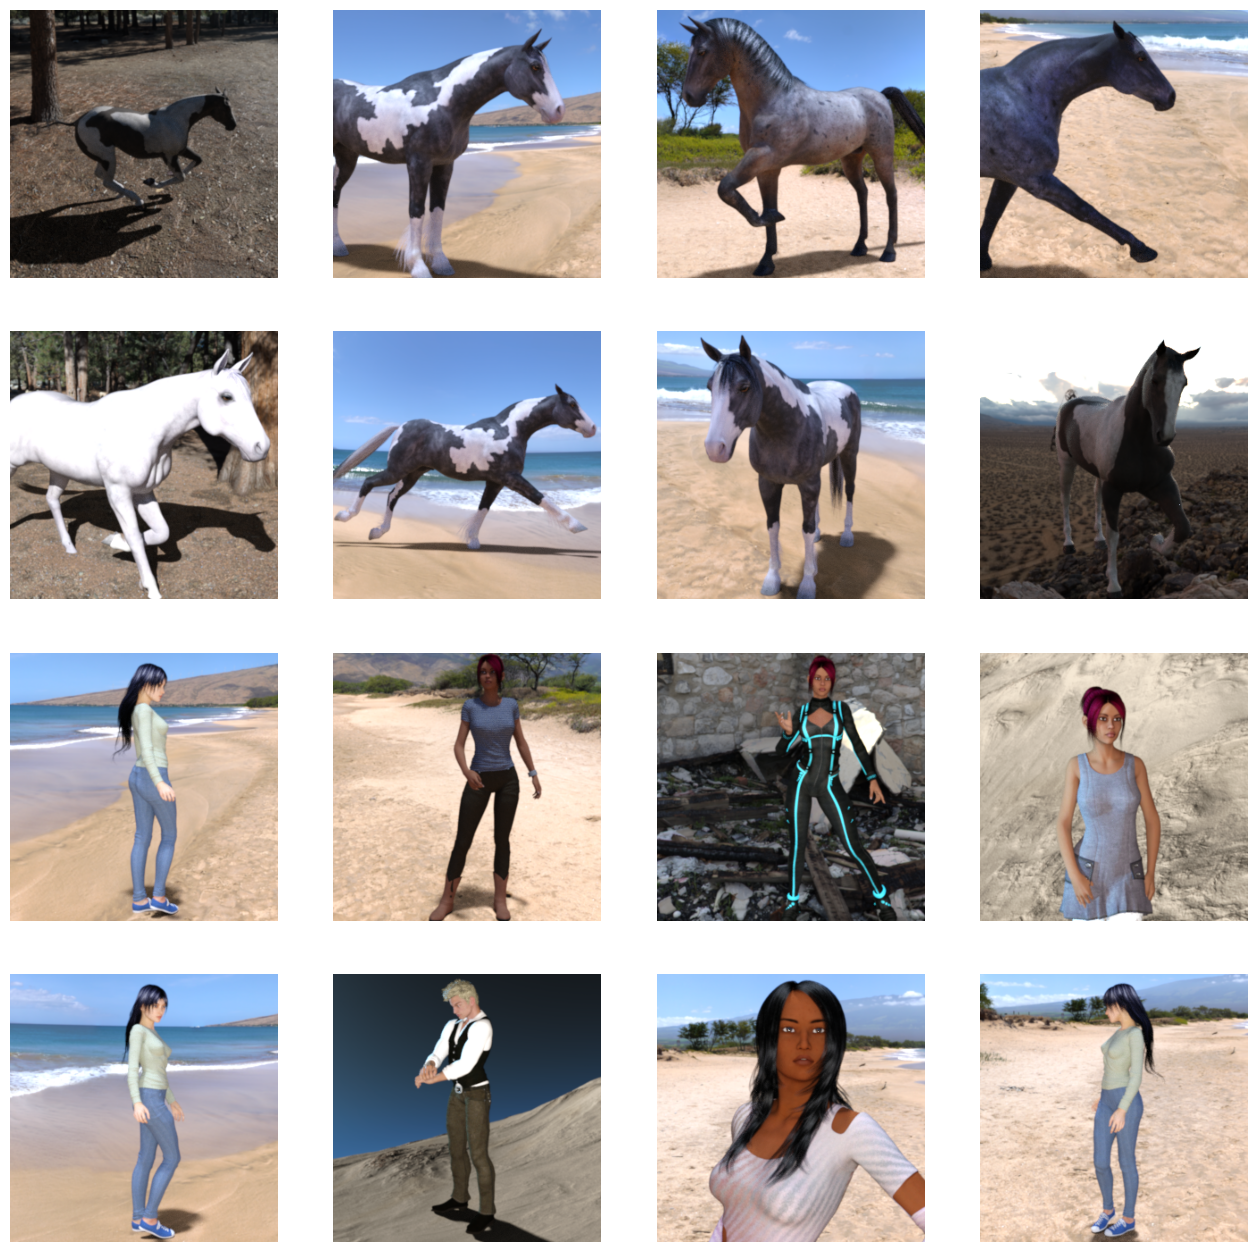

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname)
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a Small Model from Scratch

In [7]:
import tensorflow as tf

You then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers. Note that because this is a two-class classification problem, i.e. a binary classification problem, you will end your network with a sigmoid activation. This makes the output value of your network a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [8]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 64)        0

The "output shape" column shows how the size of your feature map evolves in each successive layer. As you saw in an earlier lesson, the convolution layers removes the outermost pixels of the image, and each pooling layer halves the dimensions.

Next, you'll configure the specifications for model training. You will train the model with the [`binary_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) loss because it's a binary classification problem, and the final activation is a sigmoid. (For a refresher on loss metrics, see this [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) You will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, you will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [10]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### Data Preprocessing

Next step is to set up the data generators that will read pictures in the source folders, convert them to `float32` tensors, and feed them (with their labels) to the model. You'll have one generator for the training images and one for the validation images. These generators will yield batches of images of size 300x300 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (i.e. It is uncommon to feed raw pixels into a ConvNet.) In this case, you will preprocess the images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras, this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 1027 images belonging to 2 classes.


You can start training for 15 epochs -- this may take a few minutes to run.

Do note the values per epoch.

The loss and accuracy are great indicators of progress in training. loss measures the current model prediction against the known labels, calculating the result. accuracy, on the other hand, is the portion of correct guesses.

In [12]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=15,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 11s 1s/step - loss: 0.7138 - accuracy: 0.5417
Epoch 2/15
8/8 [==============================] - 11s 1s/step - loss: 0.6727 - accuracy: 0.6774
Epoch 3/15
8/8 [==============================] - 11s 1s/step - loss: 0.6712 - accuracy: 0.6285
Epoch 4/15
8/8 [==============================] - 10s 1s/step - loss: 0.6209 - accuracy: 0.6474
Epoch 5/15
8/8 [==============================] - 10s 1s/step - loss: 0.8740 - accuracy: 0.7653
Epoch 6/15
8/8 [==============================] - 11s 1s/step - loss: 0.4957 - accuracy: 0.8209
Epoch 7/15
8/8 [==============================] - 10s 1s/step - loss: 0.4994 - accuracy: 0.8242
Epoch 8/15
8/8 [==============================] - 11s 1s/step - loss: 0.3037 - accuracy: 0.8754
Epoch 9/15
8/8 [==============================] - 10s 1s/step - loss: 0.2487 - accuracy: 0.8921
Epoch 10/15
8/8 [==============================] - 11s 1s/step - loss: 0.1573 - accuracy: 0.9433
Epoch 11/15
8/8 [======================

### Model Prediction

Now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

_**Note:** Old versions of the Safari browser might have compatibility issues with the code block below. If you get an error after you select the images(s) to upload, you can consider updating your browser to the latest version. If not possible, please comment out or skip the code block below, uncomment the next code block and run it._

In [13]:
## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")


KeyboardInterrupt: 